In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

C:\Users\yashs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\yashs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class FruitDataset(Dataset):
    def __init__(self, dataset_dir):
        self.DATASET_DIR = dataset_dir

        with open(f"./{dataset_dir}/fruits.txt", "r") as f:
            self.fruits = f.read().split(";")
        self.fruit_image_count = [
            len(os.listdir(f"./{dataset_dir}/{fruit}")) for fruit in self.fruits
        ]

        self.count_cumsum = [0]
        for fruit_count in self.fruit_image_count:
            self.count_cumsum.append(self.count_cumsum[-1] + fruit_count)
        
        self.tensor_transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Resize((255, 255)),
        ])
        
    def __len__(self):
        return self.count_cumsum[-1]
    
    def binsearch(self, index):
        left, right = 0, len(self.count_cumsum)
        while left <= right:
            middle_idx = left + (right - left) // 2
            middle_val = self.count_cumsum[middle_idx]

            if middle_val > index:
                right = middle_idx - 1
            elif middle_val < index:
                left = middle_idx + 1
            else:
                return middle_idx, self.count_cumsum[middle_idx] - index
        return right, self.count_cumsum[right] - index

    def __getitem__(self, index):
        fruit_idx, image_idx = self.binsearch(index)
        fruit = self.fruits[fruit_idx]
        image_name = os.listdir(f"./{self.DATASET_DIR}/{fruit}")[image_idx]
        image_path = f"{self.DATASET_DIR}/{fruit}/{image_name}"
        
        image = Image.open(image_path)
        return image_path, self.tensor_transform(image).float()

fruit_dataset = FruitDataset("./FIDS30")

./FIDS30/acerolas/5.jpg


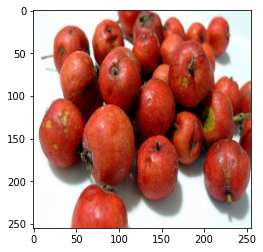

In [3]:
label, image = fruit_dataset[1]

print(label)
plt.imshow(image.int().permute(1, 2, 0))

In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()

        in_channels =  [3,  32,  64, 128, 128, 128]
        out_channels = [32, 64, 128, 128, 128, 128]
        self.latent_dim = latent_dim

        modules = []
        for in_channel, out_channel in zip(in_channels, out_channels):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channel, out_channel, 5, 2, 1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        encoder_out = 128 * 3 * 3

        self.final_encoder_layer = nn.Linear(encoder_out, self.latent_dim)

        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim)

        self.first_decoder_layer = nn.Linear(self.latent_dim, encoder_out)

        modules = []
        in_channels, out_channels = out_channels[::-1], in_channels[::-1]

        for in_channel, out_channel in zip(in_channels, out_channels):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channel, out_channel, 5, 2, 1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        batch_size = x.shape[0]
        x = self.encoder(x)
        # print("Shape after convolutions:", x.shape)
        x = x.flatten(start_dim=1)
        # print("Shape after flatten:", x.shape)
        x = self.final_encoder_layer(x)
        return x

    def reparametrize(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        std = torch.sqrt(torch.exp(logvar))
        eps = torch.rand_like(std)

        return mu, logvar, mu + std * eps
    
    def decode(self, z):
        z = self.first_decoder_layer(z)
        z = z.view(-1, 128, 3, 3)
        z = self.decoder(z)
        return z

    def forward(self, x):
        x = self.encode(x)

        mu, logvar, z = self.reparametrize(x)
        # print("Latent space size:", z.shape)

        return self.decode(z), mu, logvar


In [5]:
# for i in range(len(fruit_dataset)):
#     if fruit_dataset[i][1].shape != (3, 255, 255):
#         print(fruit_dataset[i][0])

In [6]:
model = VariationalAutoencoder(128)

_, ex_in = fruit_dataset[0]
ex_in = ex_in.unsqueeze(0)
# ex_in = torch.rand((10, 3, 255, 255))
ex_out, ex_mu, ex_logvar = model(ex_in)
ex_in.shape, ex_out.shape

(torch.Size([1, 3, 255, 255]), torch.Size([1, 3, 255, 255]))

In [7]:
# torch.mean(-0.5 * torch.sum(1 + ex_logvar - ex_mu ** 2 - ex_logvar.exp(), dim = 1), dim = 0)
# torch.sum(1 + ex_logvar - ex_mu ** 2 - ex_logvar.exp(), dim = 1)

ex_criterion = nn.MSELoss()

ex_criterion(ex_in, ex_out)

tensor(44562.6484, grad_fn=<MseLossBackward0>)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

batch_size = 64
dataloader = DataLoader(fruit_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.005)
recon_loss_criterion = nn.MSELoss()
kld_weight = 0.00025

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    for fruits, images in dataloader:
        optimizer.zero_grad()

        images = images.to(device)
        output, mu, log_var = model(images)

        recon_loss = recon_loss_criterion(images, output)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        total_loss = recon_loss + kld_weight * kld_loss
        print(recon_loss, kld_loss, total_loss)

        total_loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(31707.4590, grad_fn=<MseLossBackward0>) tensor(5.3387, grad_fn=<MeanBackward1>) tensor(31707.4609, grad_fn=<AddBackward0>)
tensor(29421.5430, grad_fn=<MseLossBackward0>) tensor(222.3528, grad_fn=<MeanBackward1>) tensor(29421.5977, grad_fn=<AddBackward0>)
tensor(32439.8398, grad_fn=<MseLossBackward0>) tensor(831.9191, grad_fn=<MeanBackward1>) tensor(32440.0469, grad_fn=<AddBackward0>)
tensor(27951.7754, grad_fn=<MseLossBackward0>) tensor(1824.7261, grad_fn=<MeanBackward1>) tensor(27952.2324, grad_fn=<AddBackward0>)
tensor(29247.2461, grad_fn=<MseLossBackward0>) tensor(966.8878, grad_fn=<MeanBackward1>) tensor(29247.4883, grad_fn=<AddBackward0>)
tensor(29621.8535, grad_fn=<MseLossBackward0>) tensor(3424.7454, grad_fn=<MeanBackward1>) tensor(29622.7090, grad_fn=<AddBackward0>)


  0%|          | 0/10 [01:18<?, ?it/s]


KeyboardInterrupt: 

In [1]:
log_var.shape

NameError: name 'log_var' is not defined

In [10]:
z = torch.randn(1, model.latent_dim)
z = z.to(device)

samples = model.decode(z)